In [18]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd
import utils


In [2]:
def load_data():
    dataset = pd.read_excel('data.xlsx')
    print("\n")
    print('Loading Dataset shape: {}'.format(dataset.shape))
    return dataset

In [3]:
def train_test_lazy_classifier(X, y, vectorizer):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                            y, stratify=y, random_state=0)
    
    X_train_vectors = vectorizer.fit_transform(X_train)
    X_test_vectors = vectorizer.transform(X_test)

    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train_vectors.A, X_test_vectors.A, y_train, y_test)
    print("\n")
    #get best F1 Score model
    models = models.sort_values(by=['ROC AUC'] , ascending=False)
    print(models)
    print("Best Model: {}".format(models.index[0]))
    best_model = clf.models[models.index[0]]
    return vectorizer, best_model


In [4]:
dataset = load_data()
dataset = utils.preprocess(dataset)



Loading Dataset shape: (1778, 8)


In [5]:
dataset.shape

(1778, 8)

<AxesSubplot:>

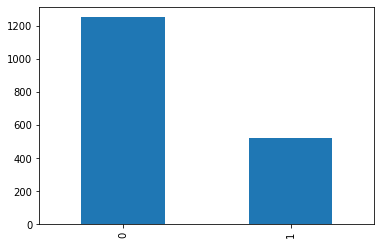

In [17]:
dataset.is_subjective_label.value_counts().plot(kind='bar')

In [6]:
X, y = dataset['preprocessed_text'], dataset['is_subjective_label']
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,1))
vectorizer, best_model = train_test_lazy_classifier(X, y, vectorizer)

100%|██████████| 29/29 [00:31<00:00,  1.08s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.75               0.72     0.72      0.76   
LogisticRegression                 0.73               0.69     0.69      0.73   
BernoulliNB                        0.78               0.69     0.69      0.76   
ExtraTreesClassifier               0.78               0.68     0.68      0.76   
PassiveAggressiveClassifier        0.69               0.68     0.68      0.70   
AdaBoostClassifier                 0.78               0.68     0.68      0.76   
LinearSVC                          0.69               0.66     0.66      0.70   
XGBClassifier                      0.76               0.66     0.66      0.74   
Perceptron                         0.71               0.66     0.66      0.71   
NuSVC                              0.77               0.65  

In [7]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', best_model['classifier'])
])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [9]:
params = {
 'tfidf__max_features':[200, 500, 1000, 2000],
 'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3)],
}

In [10]:
grid_search = GridSearchCV(pipe, cv=5, param_grid=params, n_jobs=-1, scoring='f1')

In [11]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', NearestCentroid())]),
             n_jobs=-1,
             param_grid={'tfidf__max_features': [200, 500, 1000, 2000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3),
                                                (2, 3), (3, 3)]},
             scoring='f1')

In [12]:
grid_search.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1000)),
                ('clf', NearestCentroid())])

In [13]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.544
Best parameters set:
	tfidf__max_features: 1000
	tfidf__ngram_range: (1, 1)


In [14]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       314
           1       0.59      0.58      0.58       131

    accuracy                           0.76       445
   macro avg       0.71      0.71      0.71       445
weighted avg       0.76      0.76      0.76       445



In [19]:
print(confusion_matrix(y_test, y_pred))

[[261  53]
 [ 55  76]]
